# Try correlating hash values to see if we recover operons/regulons


In [1]:
setwd("..")

In [2]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=7)
# disable scientific notation (for plot axes)
options(scipen = 999)

In [4]:
library(readr)
library(dplyr)
library(tibble)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)

## Functions

In [5]:
# transform the square correlation matrix into long format
cor_to_long <- function(m){
    #df <- m %>%
    #  as.data.frame %>% 
    #  tibble::rownames_to_column() %>% 
    #  tidyr::pivot_longer(-rowname) %>%
    #  select(row = rowname, col = name, corr = value) %>%
    #  filter(row != col)
    df <- data.frame(row=rownames(m)[row(m)], col=colnames(m)[col(m)], corr=c(m)) %>%
      filter(row != col)
    df <- df %>% 
      mutate(row = as.numeric(row)) %>% # convery minhash back to numeric to perserve joins later
      mutate(col = as.numeric(row))
} 

## Investigate how many cDNAs (transcripts) are represented in the sketch


In [6]:
pa14_hash_map <- read_csv("outputs/txomes_sourmash_sketch_singleton/pa14.csv", show_col_types = F)

In [7]:
head(pa14_hash_map)

minhash,abund,name
<dbl>,<dbl>,<chr>
5477674659550458,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
8655017080968988,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
13224287242744290,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
14457255237130468,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit"
0,NA,ABJ14957 cdna chromosome:ASM1462v1:Chromosome:483:2027:1 gene:PA14_00010 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaA description:chromosomal replication initiator protein DnaA
0,NA,"ABJ14958 cdna chromosome:ASM1462v1:Chromosome:2056:3159:1 gene:PA14_00020 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaN description:DNA polymerase III, beta chain"


In [8]:
table(is.na(pa14_hash_map$abund))


FALSE  TRUE 
 5611  2617 

In [9]:
# how many unique sequences were there in the pa14 "transcriptome" (cDNA file)?
length(unique(pa14_hash_map$name))

[1] 5892

In [10]:
# how many of these sequences ended up with a hash representing it?
pa14_hash_map %>%
  select(abund, name) %>%
  distinct() %>%
  group_by(abund) %>%
  tally()

abund,n
<dbl>,<int>
1,3275
2,2
NA,2617


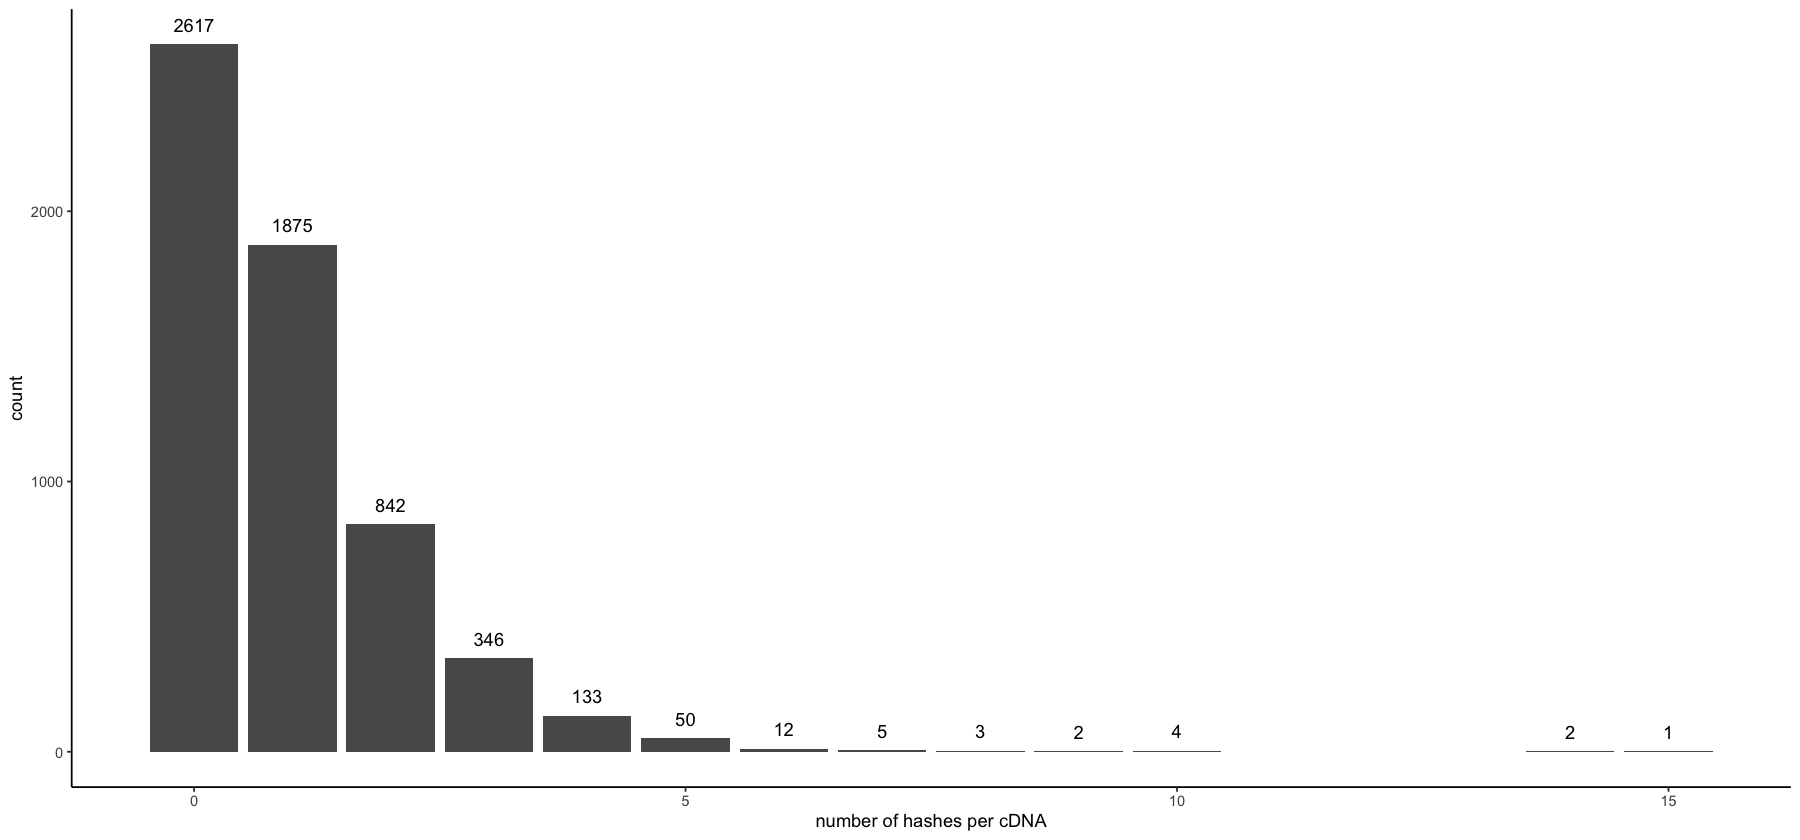

In [11]:
# how many hashes did each transcript end up having?
pa14_hash_map_tally <- pa14_hash_map %>%
  filter(!is.na(abund)) %>%
  group_by(name) %>%
  tally()

pa14_hash_map_tally_tmp <- pa14_hash_map %>%
  filter(is.na(abund)) %>%
  group_by(name) %>%
  tally() %>%
  mutate(n = 0) 

pa14_hash_map_tally <- bind_rows(pa14_hash_map_tally, pa14_hash_map_tally_tmp)

ggplot(pa14_hash_map_tally, aes(x = n)) +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of hashes per cDNA")

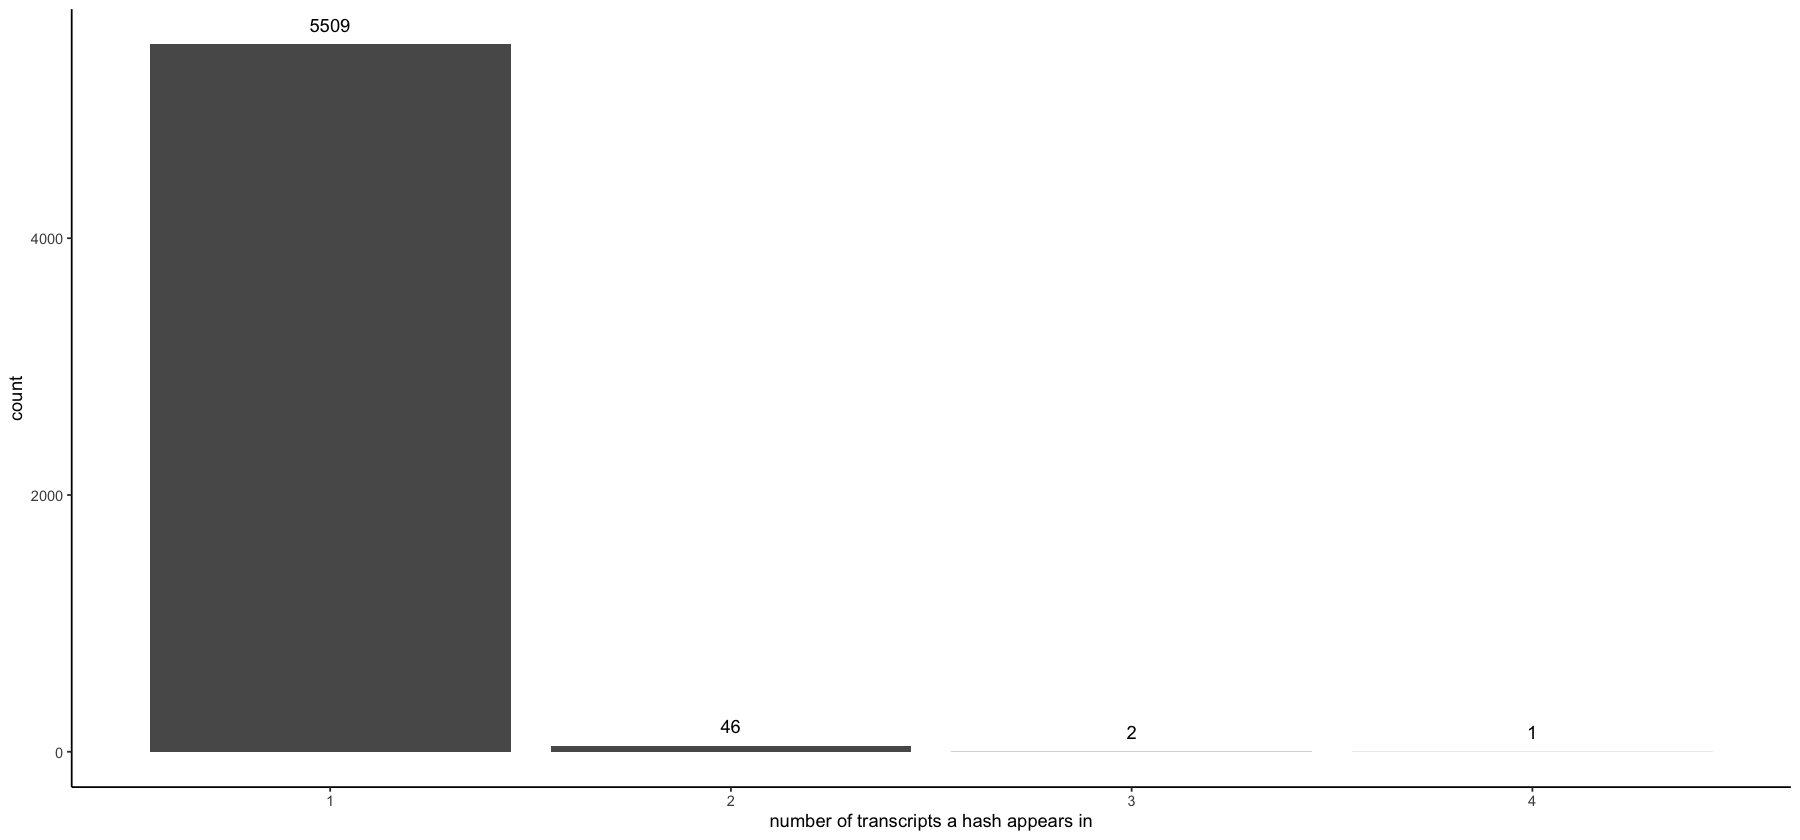

In [12]:
# how many "collisions" are there -- e.g. how many times does the same hash appear in different transcripts
pa14_hash_map_minhash_tally <- pa14_hash_map %>%
  filter(!is.na(abund)) %>%
  group_by(minhash) %>%
  tally() %>%
  arrange(desc(n))

ggplot(pa14_hash_map_minhash_tally, aes(x = n))  +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of transcripts a hash appears in")

## Read in operon metadata and backport to hashmap

In [13]:
pa14_operons <- read_csv("https://raw.githubusercontent.com/greenelab/core-accessory-interactome/master/data/metadata/PA14-operons-2021-07-19.csv", show_col_types = F)

In [14]:
pa14_transcript_to_gene <- read_csv("https://osf.io/ema5c/download", skip = 1, col_names = c("tmp", "transcript_name", "locus_tag"), show_col_types = F) %>%
  select(-tmp)

In [15]:
head(pa14_operons)

operon-id,operon_name,locus_tag,start,end,strand,gene_name,source_database,pmid
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00010,483,2027,1,dnaA,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00020,2056,3159,1,dnaN,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00030,3169,4278,1,recF,DOOR,18988623
operon-8958,dnaA-dnaN-recF-gyrB,PA14_00050,4275,6695,1,gyrB,DOOR,18988623
operon-8959,PA14_00070-PA14_00060,PA14_00060,7018,7791,-1,NA,DOOR,18988623
operon-8959,PA14_00070-PA14_00060,PA14_00070,7803,8339,-1,NA,DOOR,18988623


In [16]:
pa14_hash_map <- pa14_hash_map %>%
  mutate(transcript_name = gsub(" .*", "", name)) %>%
  left_join(pa14_transcript_to_gene, by = "transcript_name") %>%
  left_join(pa14_operons, by = "locus_tag")

In [17]:
head(pa14_hash_map)
length(unique(pa14_hash_map$`operon-id`))

minhash,abund,name,transcript_name,locus_tag,operon-id,operon_name,start,end,strand,gene_name,source_database,pmid
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
5477674659550458,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
8655017080968988,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
13224287242744290,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
14457255237130468,1,"ABJ15654 cdna chromosome:ASM1462v1:Chromosome:5669268:5672348:-1 gene:PA14_63605 gene_biotype:nontranslating_CDS transcript_biotype:nontranslating_CDS gene_symbol:fdnG description:formate dehydrogenase-O, major subunit",ABJ15654,PA14_63605,operon-10022,fdnG-fdnH-fdnI,5669268,5672348,-1,fdnG,DOOR,18988623
0,NA,ABJ14957 cdna chromosome:ASM1462v1:Chromosome:483:2027:1 gene:PA14_00010 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaA description:chromosomal replication initiator protein DnaA,ABJ14957,PA14_00010,operon-8958,dnaA-dnaN-recF-gyrB,483,2027,1,dnaA,DOOR,18988623
0,NA,"ABJ14958 cdna chromosome:ASM1462v1:Chromosome:2056:3159:1 gene:PA14_00020 gene_biotype:protein_coding transcript_biotype:protein_coding gene_symbol:dnaN description:DNA polymerase III, beta chain",ABJ14958,PA14_00020,operon-8958,dnaA-dnaN-recF-gyrB,2056,3159,1,dnaN,DOOR,18988623


[1] 1232

In [18]:
table(is.na(pa14_hash_map$`operon-id`))


FALSE  TRUE 
 5194  3034 

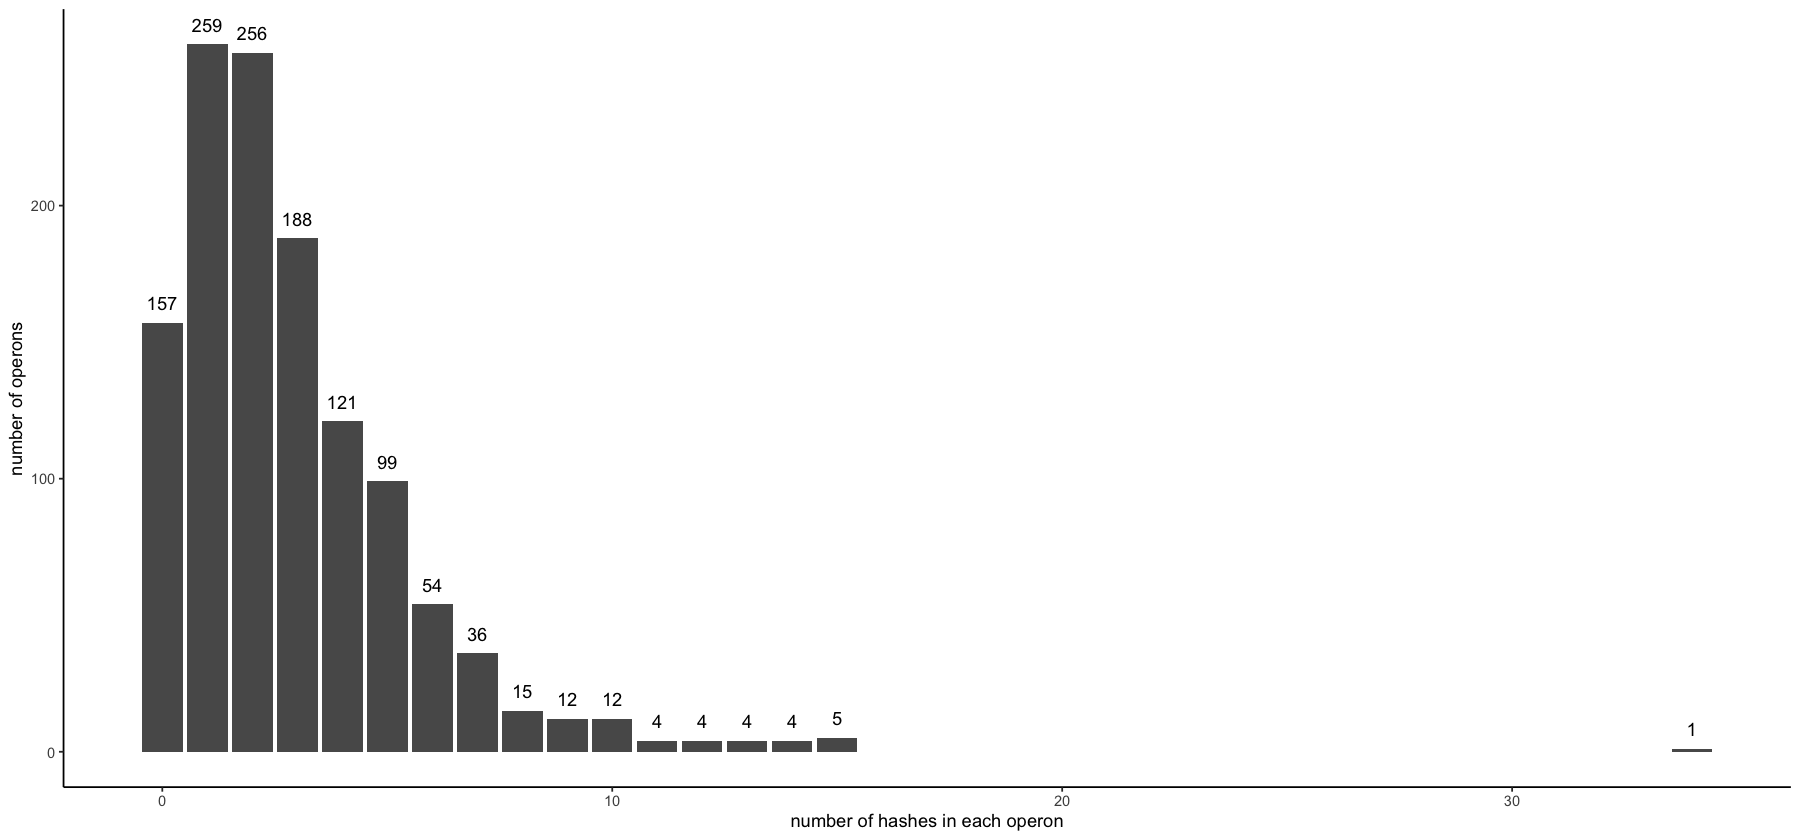

In [19]:
# does every operon have at least one hash?
pa14_hash_map_operon <- pa14_hash_map %>%
  filter(!is.na(`operon-id`))

hashes_in_operon <- pa14_hash_map_operon %>%
  replace_na(list(abund = 0)) %>%
  group_by(`operon-id`) %>%
  mutate(hashes_in_operon = sum(abund)) %>%
  select(operon_id = `operon-id`, hashes_in_operon) %>%
  distinct()

ggplot(hashes_in_operon, aes(x = hashes_in_operon)) +
  geom_bar() +
  theme_classic() +
  geom_text(stat='count', aes(label=..count..), vjust=-1) +
  labs(x = "number of hashes in each operon", y = "number of operons")

In [20]:
pa14_hash_map_operon_small <- pa14_hash_map_operon %>%
  select(minhash, operon_id = `operon-id`) %>%
  distinct()

## Read in data for hash correlations

In [21]:
metadata <- read_tsv("inputs/metadata.tsv", show_col_types = F)
metadata_pa14 <- metadata %>%
  filter(strain_type == "PA14")

In [22]:
pa14_files <- paste0("outputs/srx_sourmash_sketch_filtered_csv/", metadata_pa14$experiment, "_k21.csv")
raw_pa14_kmers_long <- pa14_files %>%
  purrr::set_names() %>%
  map_dfr(read_csv, skip = 1, col_names = c("minhash", "abund"), show_col_types = F, .id = "sample") %>%  # read in sketches
  mutate(sample = gsub("_k21\\.csv", "", basename(sample)))

In [23]:
# pivot from long to wide; shares minhash index
raw_pa14_kmers <- raw_pa14_kmers_long %>%
  pivot_wider(id_cols = minhash, names_from = sample, values_from = abund) %>%
  replace(is.na(.), 0)                    # replace NAs with zero abund

In [24]:
# make a df and vector to filter k-mers that aren't common across libraries
raw_pa14_kmers_pa <- raw_pa14_kmers %>%
  column_to_rownames("minhash") %>%
  mutate_if(is.numeric, ~1 * (. != 0))

In [25]:
# if we kept only k-mers that occurred in > X of the 541 samples, how many k-mers will be left?
table(rowSums(raw_pa14_kmers_pa) > 100)


  FALSE    TRUE 
1454132    7601 

In [26]:
keep_kmers <- rownames(raw_pa14_kmers_pa)[rowSums(raw_pa14_kmers_pa) > 100]

In [27]:
raw_pa14_kmers_filt <- raw_pa14_kmers %>%
  filter(minhash %in% keep_kmers)

## Raw hash correlations

In [28]:
# do raw correlation analysis; no normalization
tmp <- raw_pa14_kmers_filt %>%
  column_to_rownames("minhash") %>%
  t()

raw_pa14_kmers_filt_cor <- cor(tmp, method = "pearson")

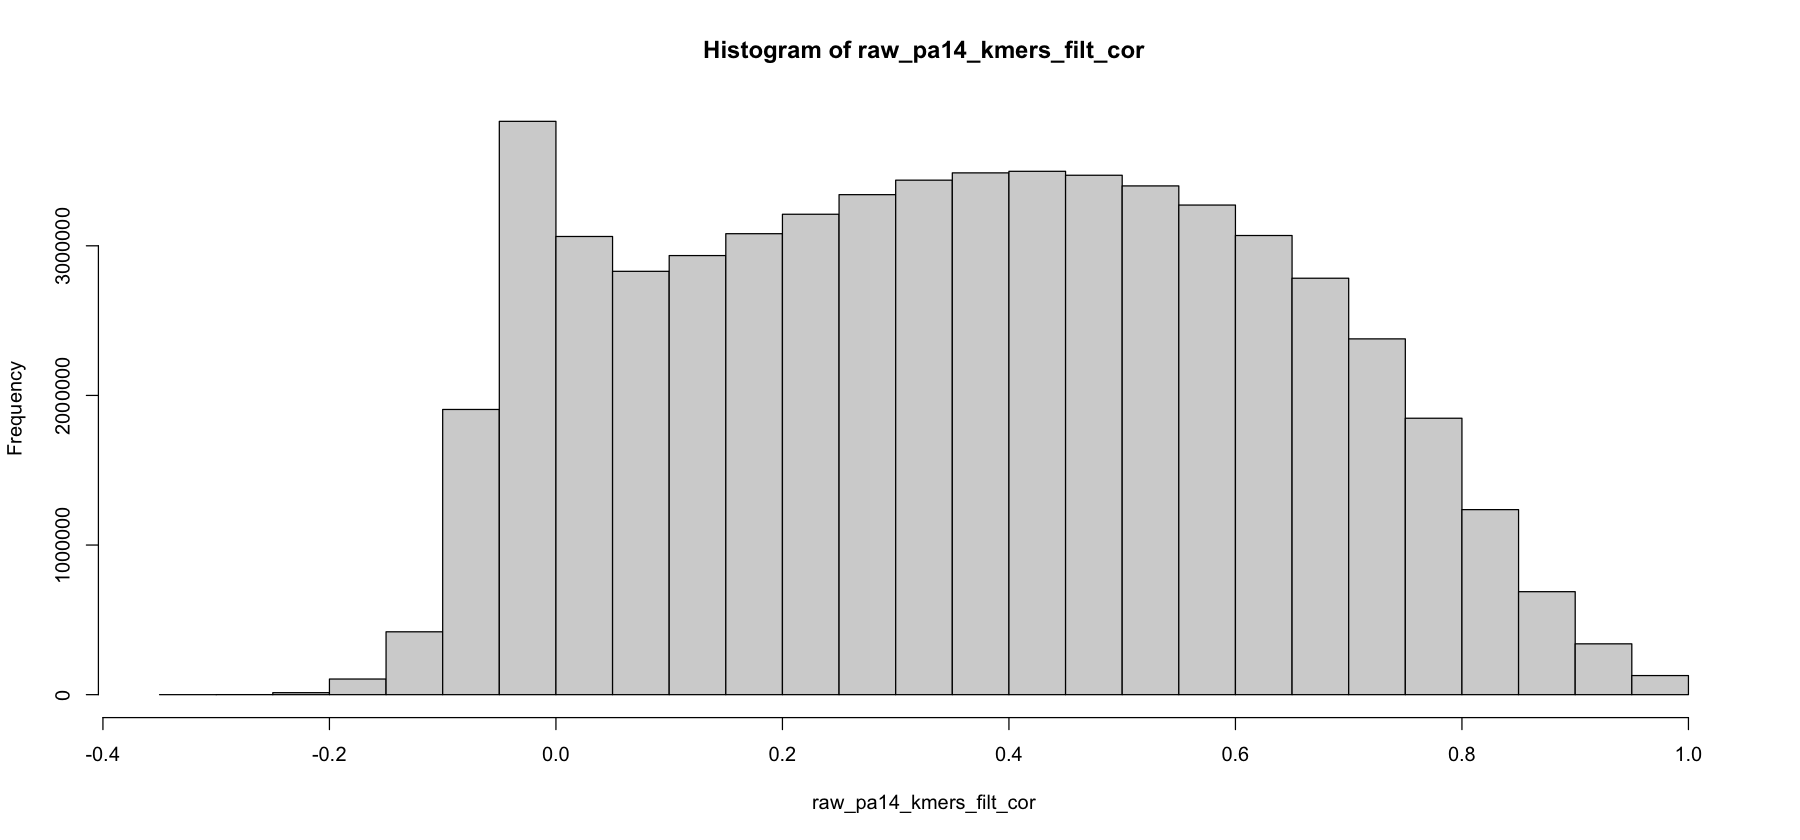

In [29]:
hist(raw_pa14_kmers_filt_cor)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



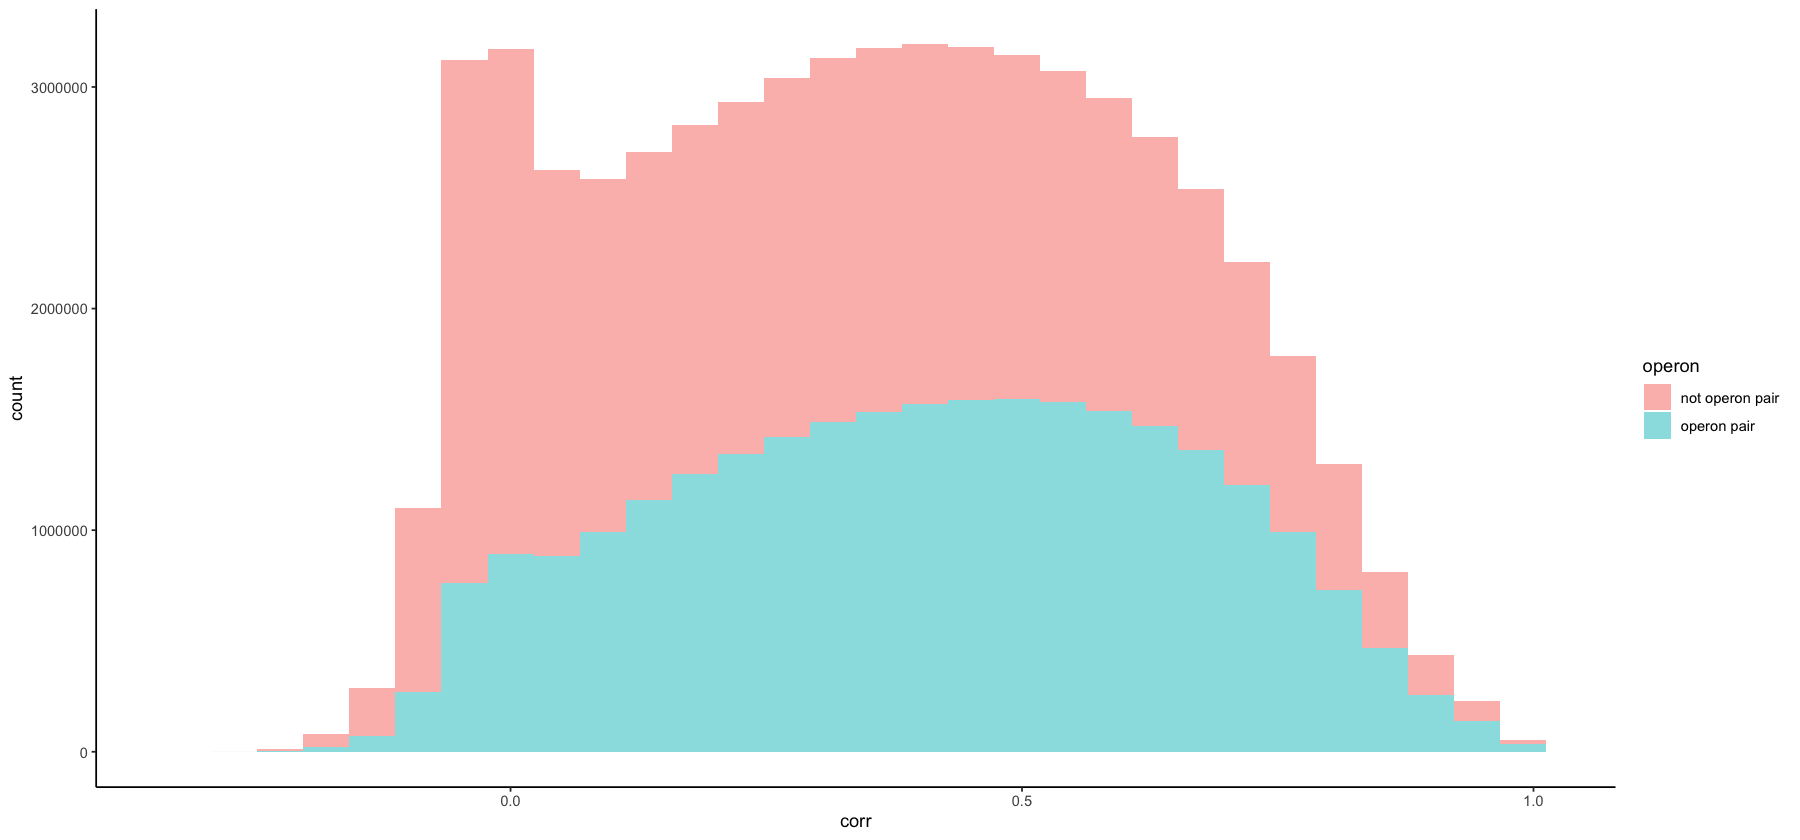

In [30]:
raw_pa14_kmers_cor_df <- cor_to_long(raw_pa14_kmers_filt_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(raw_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()

## Normalized hash correlations

normalization was done with Seurat in a different script:

```
raw_pa14_kmers <- raw_pa14_kmers %>%
  column_to_rownames("minhash")

seurat<-CreateSeuratObject(counts = raw_pa14_kmers, min.cells = 3, min.features = 350, project = "pa14")
lognorm_pa14_kmers <- NormalizeData(object = seurat, normalization.method = "LogNormalize", scale.factor = 1e4)
clrnorm_pa14_kmers <- NormalizeData(object = seurat, normalization.method = "CLR", scale.factor = 1e4)
cpmnorm_pa14_kmers <- NormalizeData(object = seurat, normalization.method = "RC", scale.factor = 1e6)

# reset minhash names
seurat_norm_to_df <- function(seurat_obj){
  # extract normalized values and put them into a dataframe
  # then extract minhash names and add them as the first column
  seurat_obj_df <- as.data.frame(as.matrix(GetAssayData(seurat_obj, slot = "data")))
  rownames(seurat_obj_df) <- seurat_obj@assays$RNA@counts@Dimnames[1][[1]]
  seurat_obj_df <- seurat_obj_df %>%
    rownames_to_column("minhash")
}

write_csv(seurat_norm_to_df(lognorm_pa14_kmers), "sandbox/202203_normalize/pa14_lognorm_kmers.csv")
write_csv(seurat_norm_to_df(clrnorm_pa14_kmers), "sandbox/202203_normalize/pa14_clrnorm_kmers.csv")
write_csv(seurat_norm_to_df(cpmnorm_pa14_kmers), "sandbox/202203_normalize/pa14_cpmnorm_kmers.csv")
```

pre-filtering was different than above. read in data and cor.

In [31]:
lognorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_lognorm_kmers.csv", show_col_types = F)
clrnorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_clrnorm_kmers.csv", show_col_types = F)
cpmnorm_pa14_kmers <- read_csv("sandbox/202203_normalize/pa14_cpmnorm_kmers.csv", show_col_types = F)

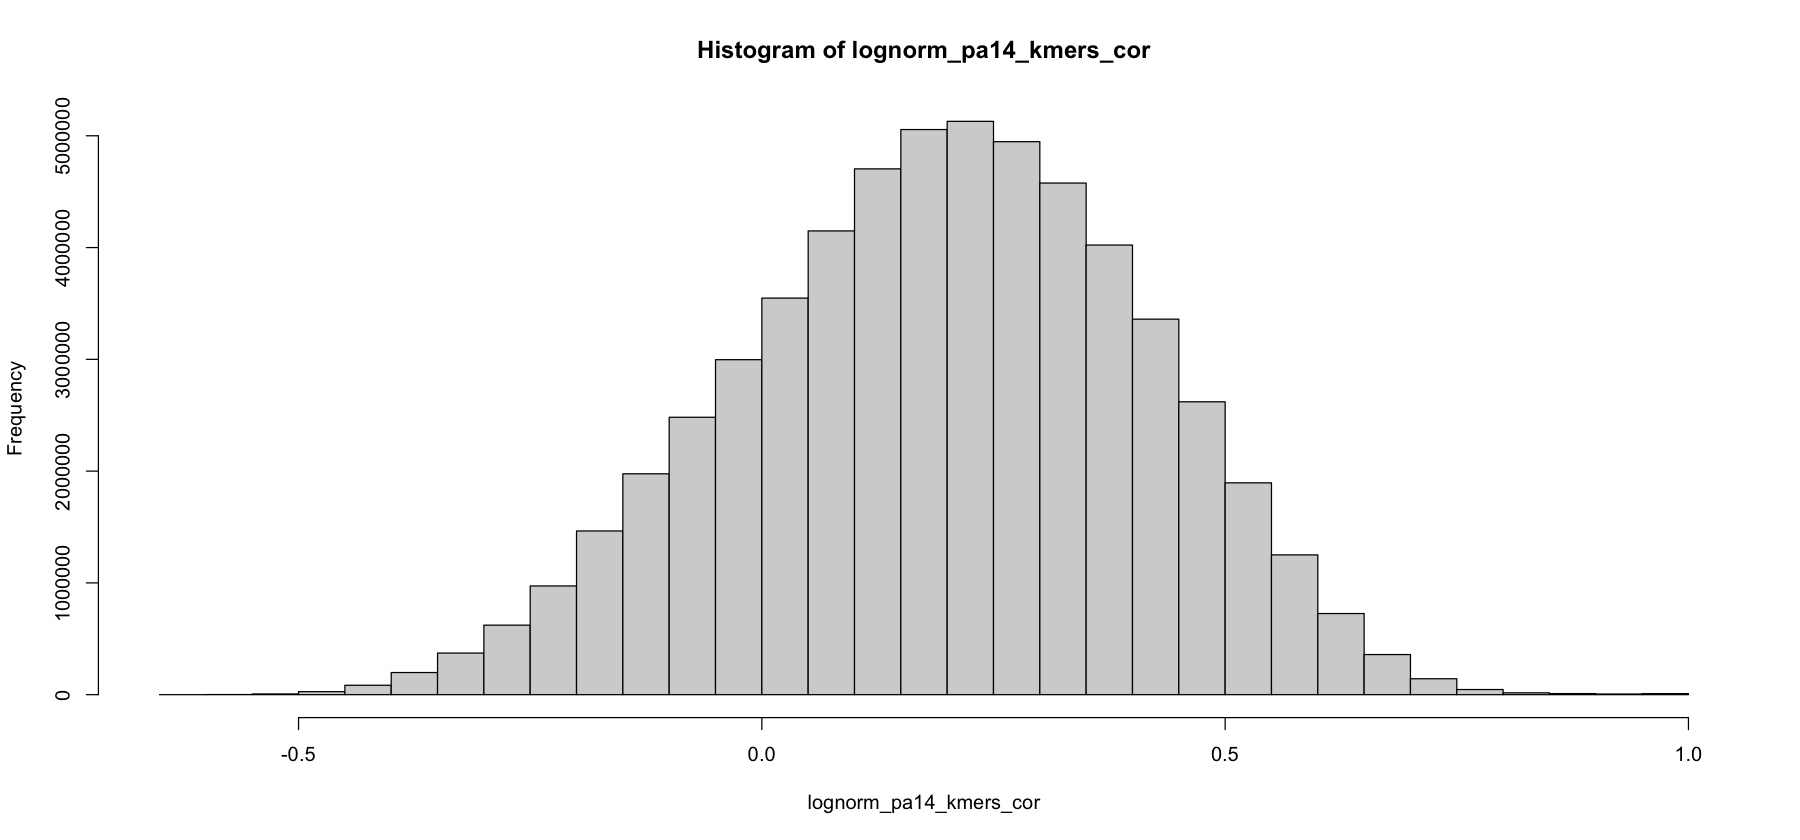

In [32]:
# do log norm correlation analysis
tmp <- lognorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

lognorm_pa14_kmers_cor <- cor(tmp, method = "pearson")
hist(lognorm_pa14_kmers_cor)

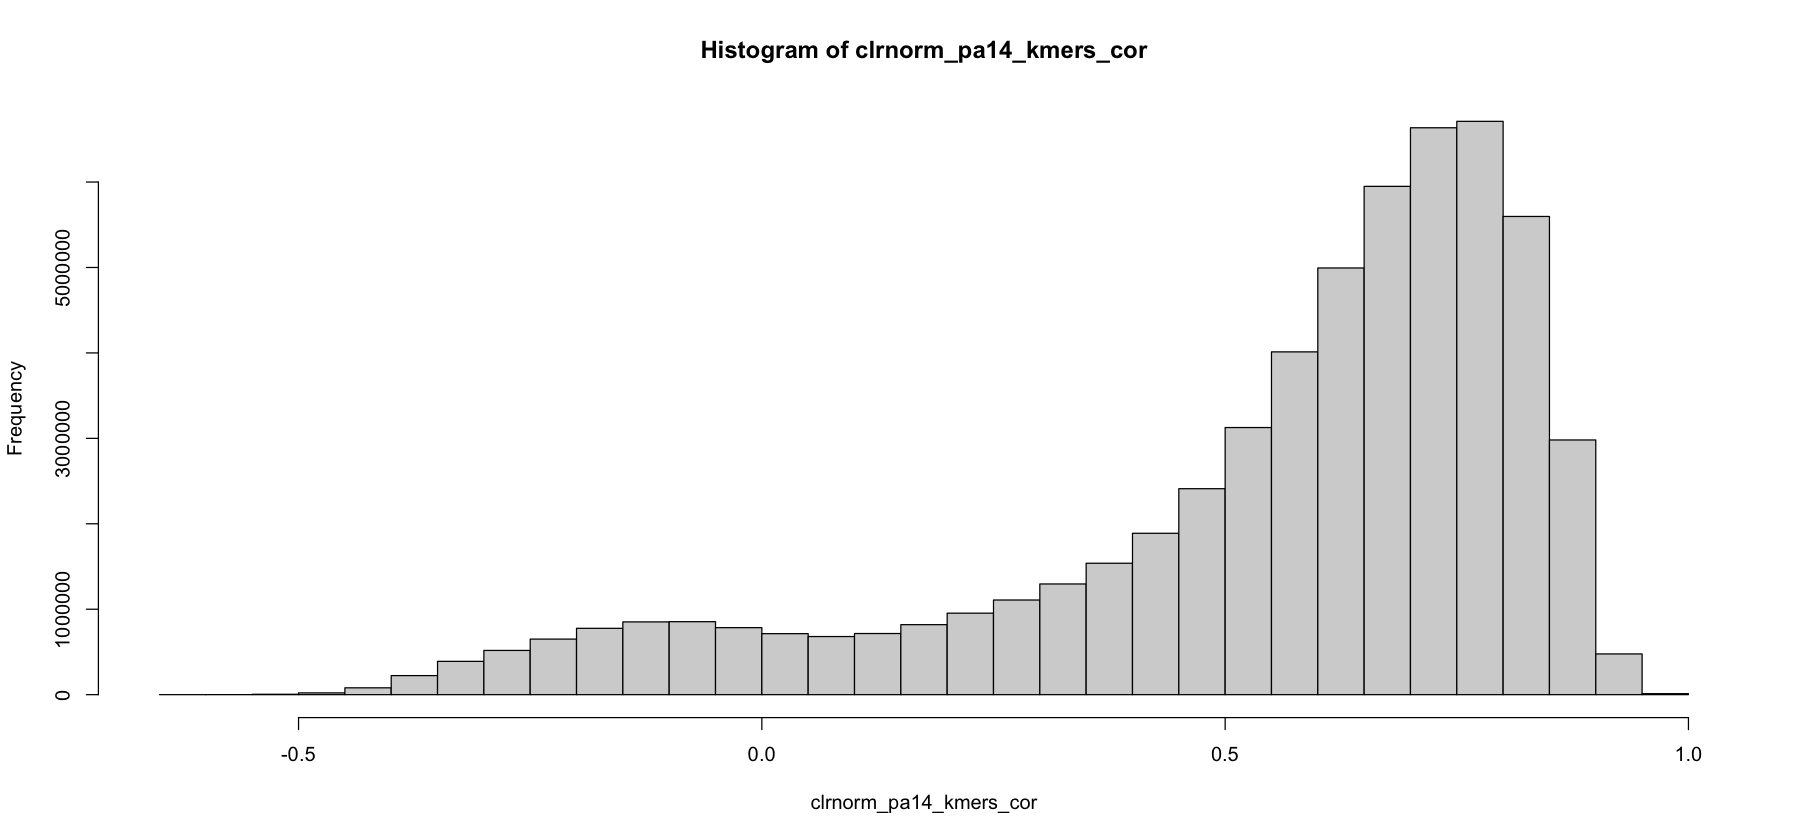

In [33]:
# do clr norm correlation analysis
tmp <- clrnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

clrnorm_pa14_kmers_cor <- cor(tmp, method = "pearson")
hist(clrnorm_pa14_kmers_cor)

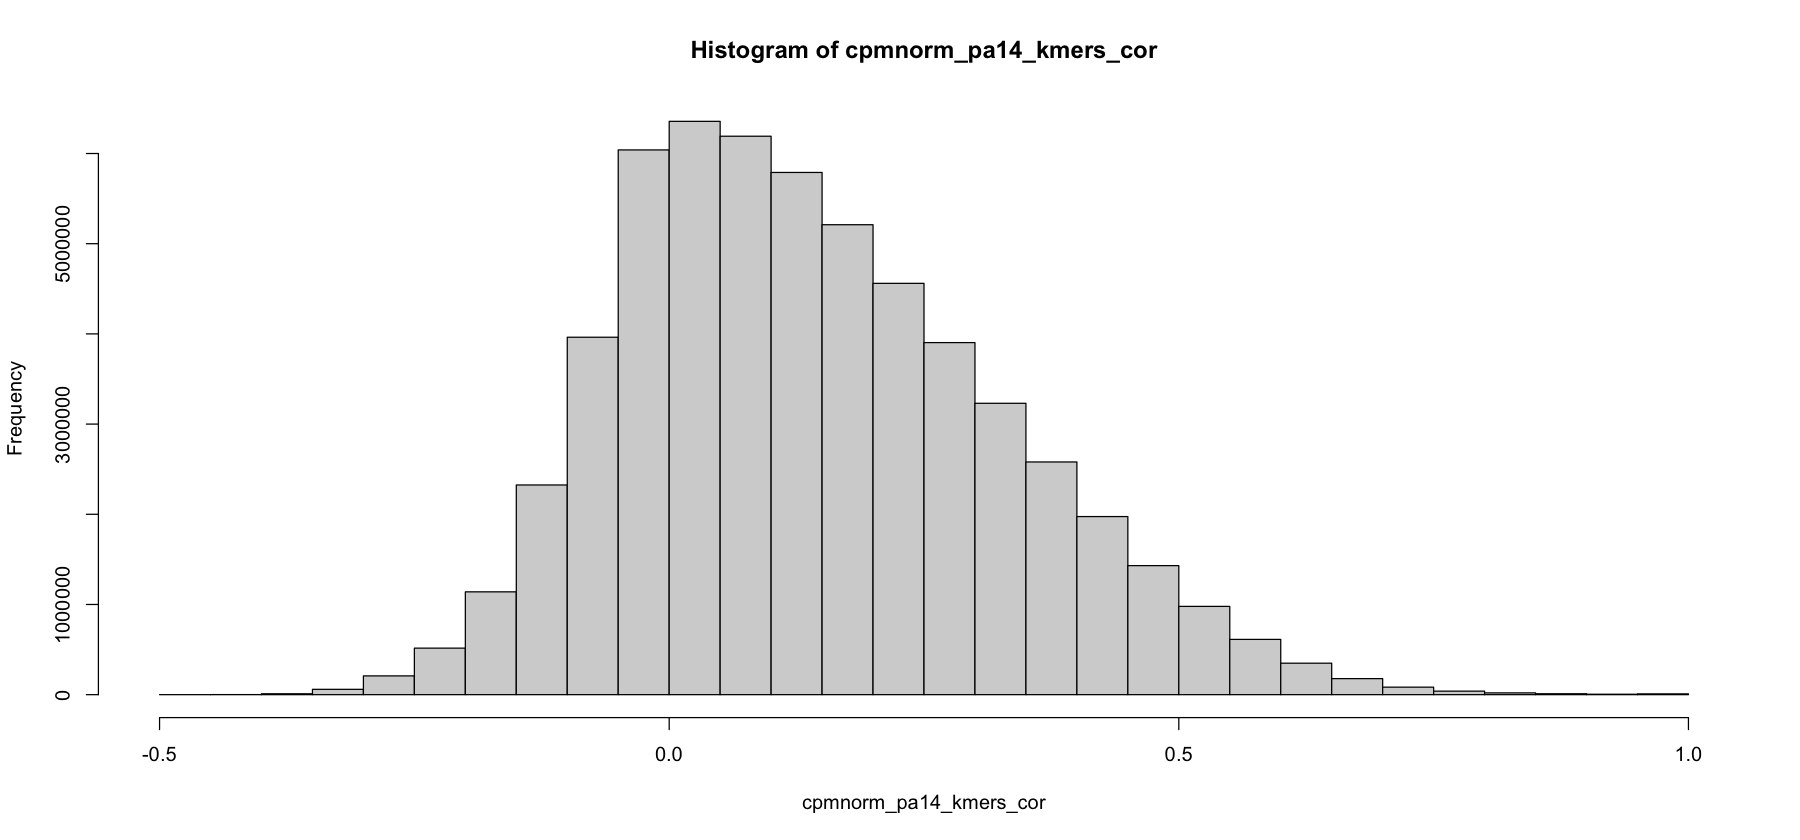

In [34]:
# do cpm norm correlation analysis
tmp <- cpmnorm_pa14_kmers %>%
  filter(minhash %in% keep_kmers) %>%
  column_to_rownames("minhash") %>%
  t()

cpmnorm_pa14_kmers_cor <- cor(tmp, method = "pearson")
hist(cpmnorm_pa14_kmers_cor)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



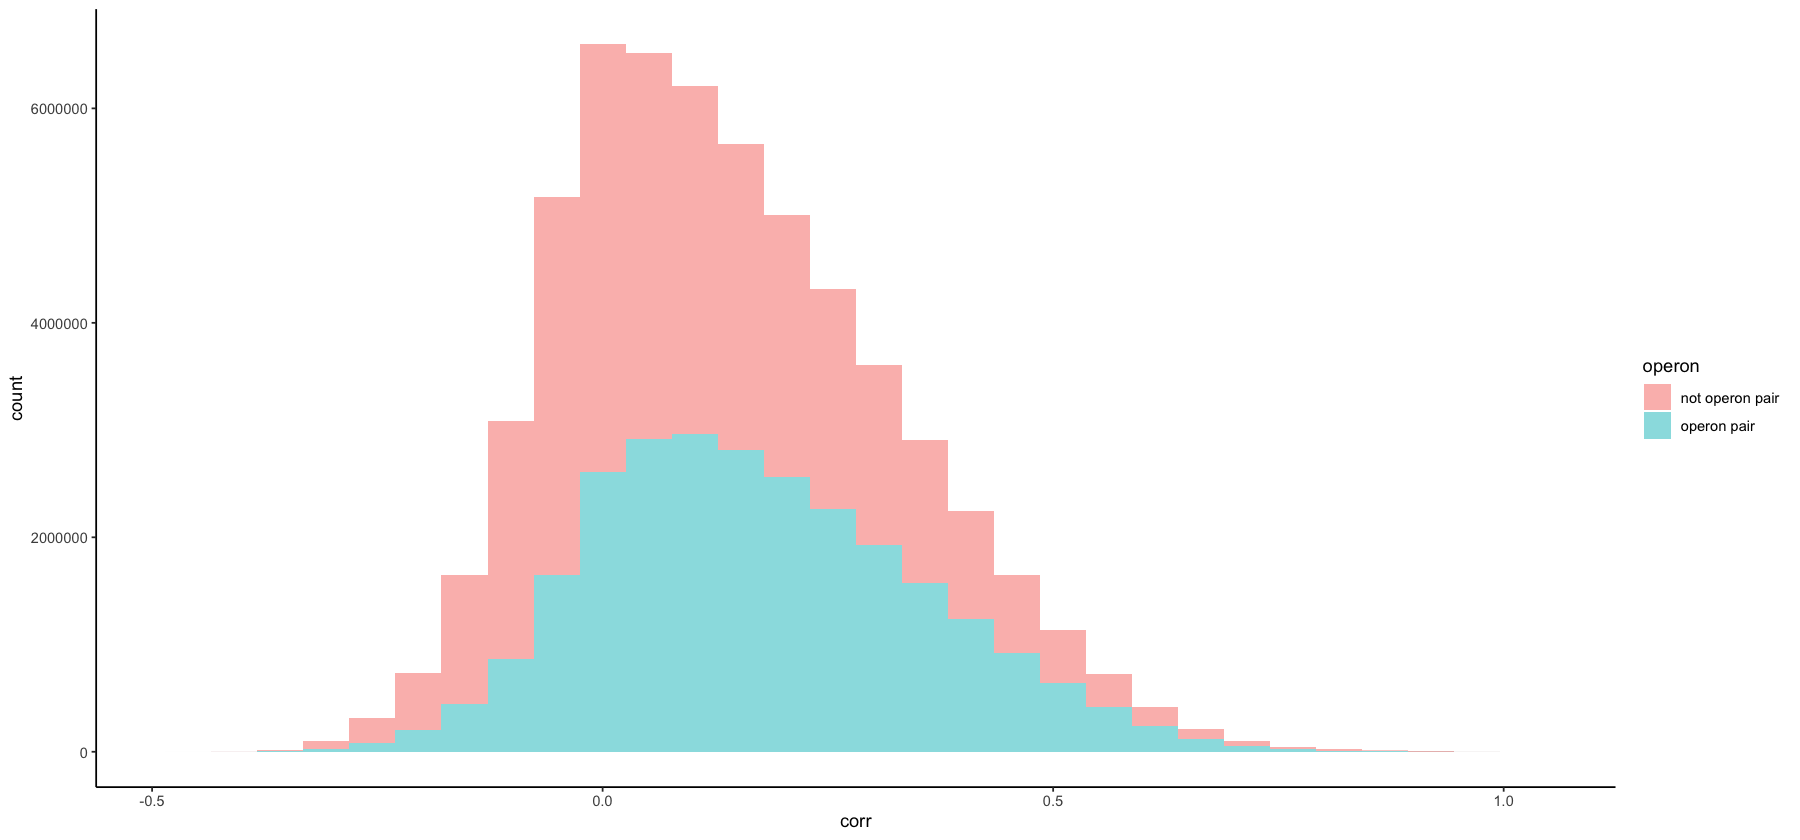

In [35]:
cpmnorm_pa14_kmers_cor_df <- cor_to_long(cpmnorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

ggplot(cpmnorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()

In [36]:
lognorm_pa14_kmers_cor_df <- cor_to_long(lognorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



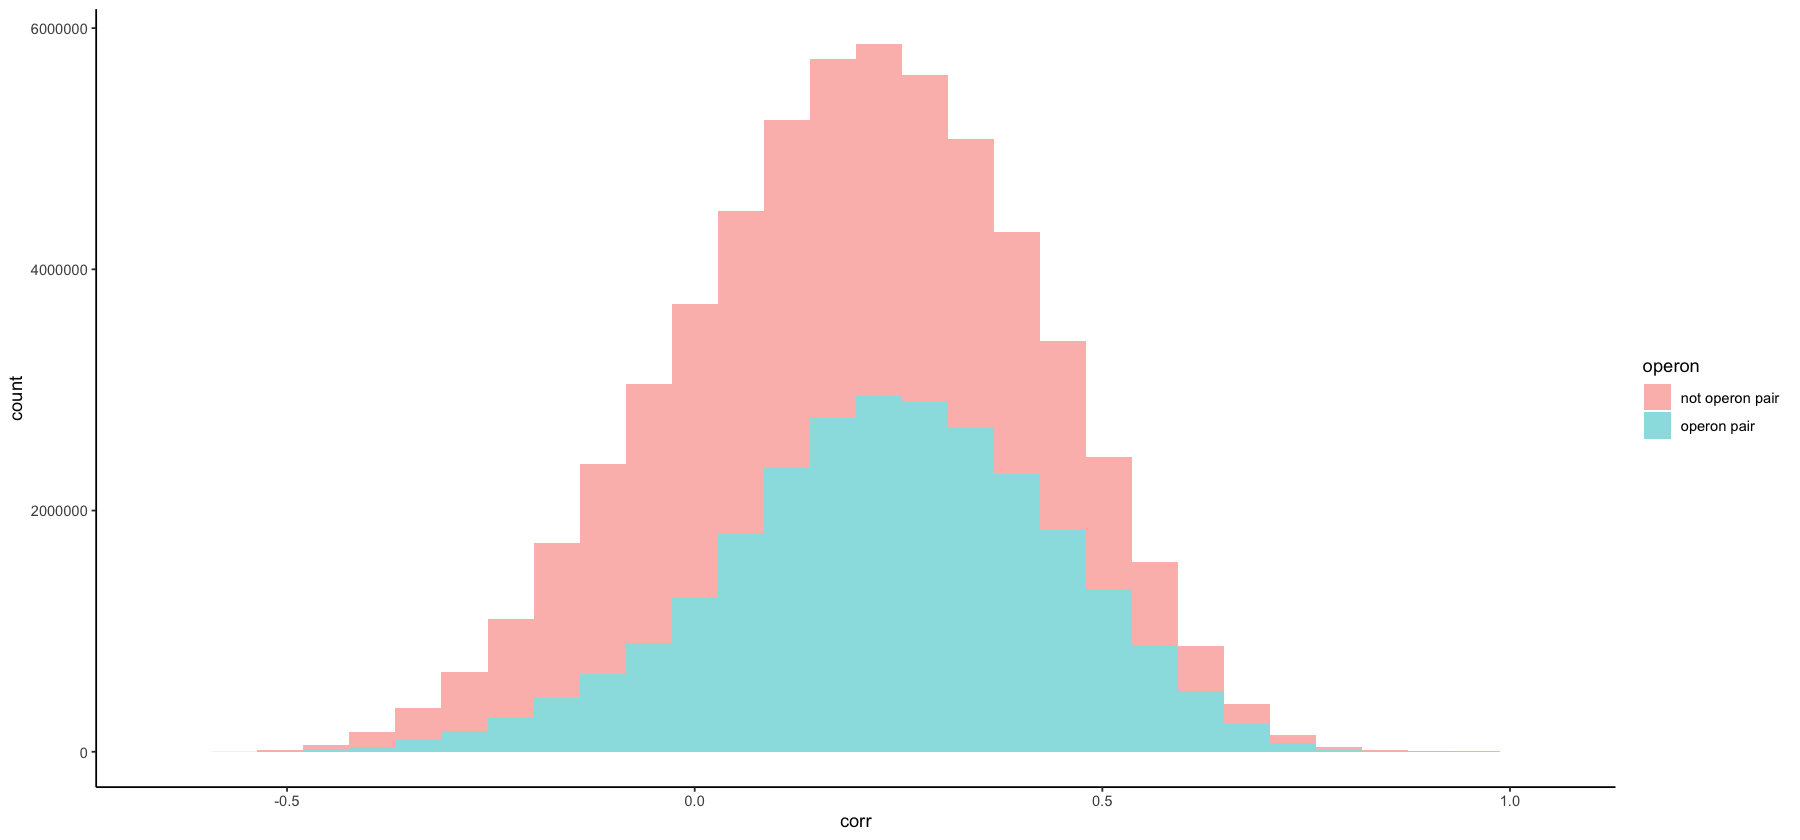

In [37]:
ggplot(lognorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()

In [38]:
clrnorm_pa14_kmers_cor_df <- cor_to_long(clrnorm_pa14_kmers_cor) %>%
  left_join(pa14_hash_map_operon_small, by = c("row" = "minhash")) %>% # determine which operon, if any, the row is part of
  select(row, col, corr, operon_id_row = operon_id) %>% # record operon identity of row
  left_join(pa14_hash_map_operon_small, by = c("col" = "minhash")) %>% # determine which operon the col is part of
  select(row, col, corr, operon_id_row, operon_id_col = operon_id) %>% # record operon identity of col
  mutate(operon = ifelse(operon_id_row == operon_id_col, "operon pair", "not operon pair")) %>% # label operon pairs
  mutate(operon = ifelse(is.na(operon), "not operon pair", operon))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



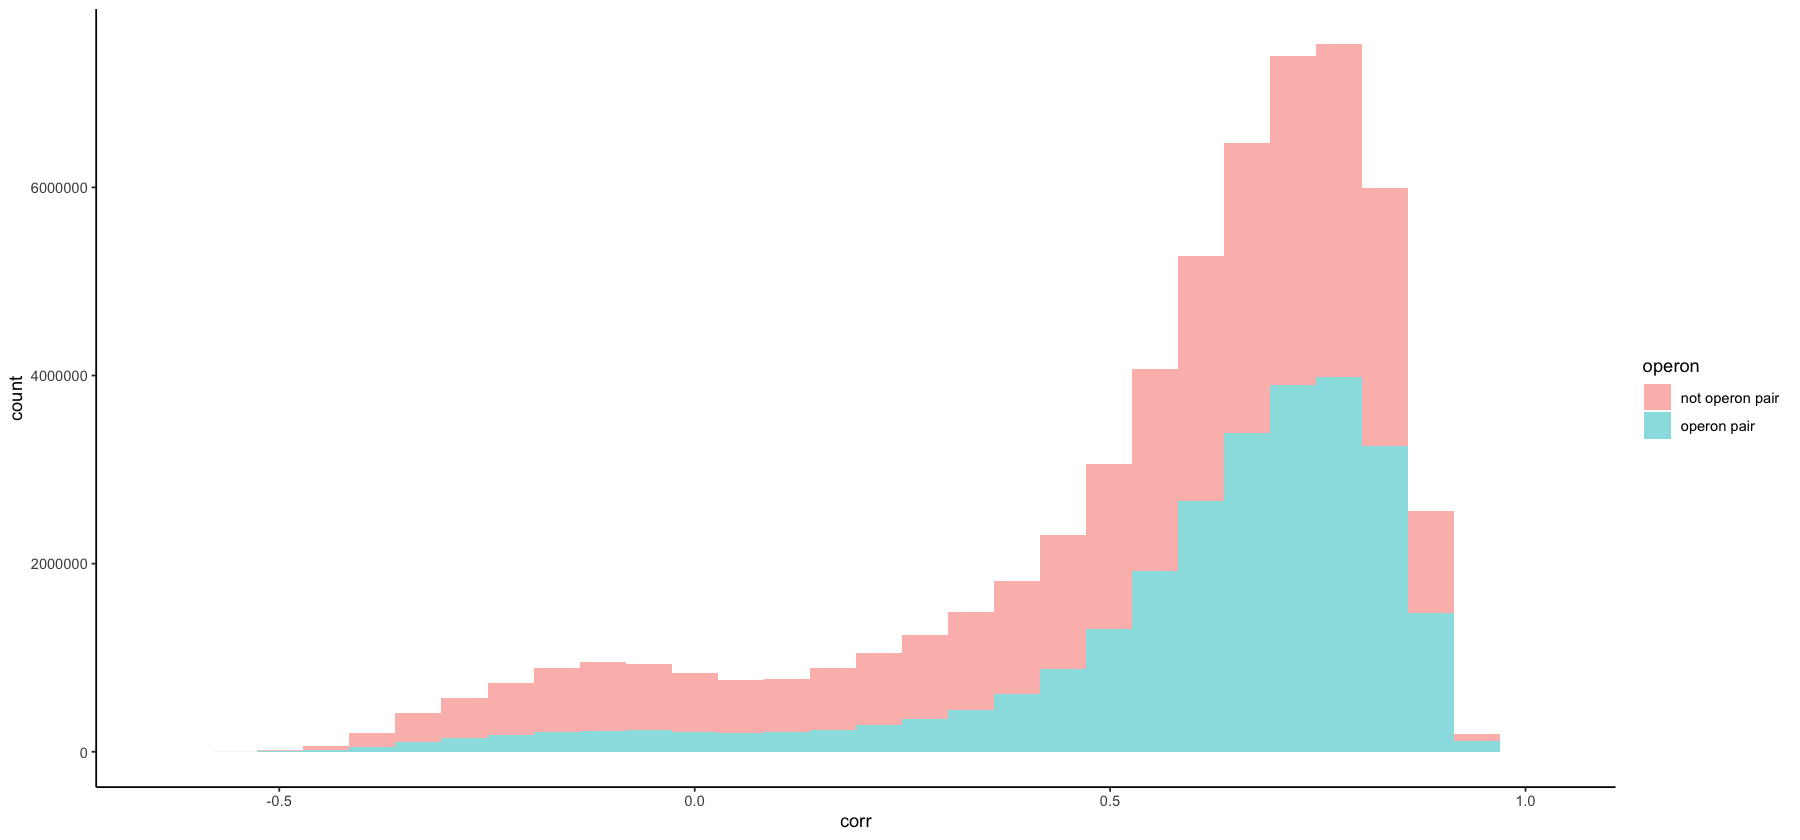

In [39]:
ggplot(clrnorm_pa14_kmers_cor_df, aes(x = corr, fill = operon)) +
  geom_histogram(alpha = .5) +
  theme_classic()